"Electric Reliability Council of Texas (ERCOT) manages the flow of electric power to more than 25 million Texas customers -- representing about 90 percent of the state’s electric load." (<a href="http://www.ercot.com/about">source</a>)

Example report: http://www.ercot.com/content/wcm/lists/143010/2018_Long-Term_Hourly_Peak_Demand_and_Energy_Forecast_Final.pdf

Data source:<BR>
http://www.ercot.com/gridinfo/load/load_hist/

In [1]:
import pandas as pd
print('pandas',pd.__version__)
import numpy
print('numpy',numpy.__version__)
import glob
from scipy.fftpack import fft, ifft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import random
import time
import matplotlib.pyplot as plt

pandas 0.25.1
numpy 1.17.2


In [5]:
def get_data():
    df = pd.read_pickle('power_data.pkl')
    return df

In [6]:
start_time=time.time()
df= get_data()
print(df.shape)
print('elapsed:',time.time()-start_time,'seconds')

(167976, 10)
elapsed: 0.02219700813293457 seconds


In [7]:
df.describe()

,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
count,167975.000000,167975.000000,167975.000000,167975.000000,167975.000000,167975.000000,167975.000000,167975.000000,167975.000000
mean,10750.165500,1391.970186,1807.496311,941.367016,12401.365720,2952.656303,6139.900493,1048.988782,37433.910311
std,2617.795704,331.218649,816.814685,264.583241,3479.523178,840.605232,1720.800790,256.279017,9475.475217
min,1702.829343,709.264584,843.435595,488.272293,5819.434172,1330.100418,2858.256918,502.288022,19269.758294
25%,8874.277680,1161.461195,1188.965179,745.238949,9991.113861,2322.747399,4924.062681,861.501815,30635.309570
50%,10218.850528,1321.677374,1463.698814,882.627172,11598.875000,2814.569200,5756.500198,1007.559102,35554.179730
75%,12177.836754,1572.836744,2162.030802,1069.997185,14194.833845,3434.578943,7044.266418,1193.381727,42521.993835
max,21256.115190,2949.198517,4438.851497,2305.722761,26499.240955,6192.252947,14166.701623,2117.399078,74665.579486


In [8]:
df.head()

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2006-01-01 01:00:00.003,7623.394894,788.305875,1026.559049,777.157535,7549.809438,1852.416802,3797.223989,639.553370,24054.420954
1,2006-01-01 01:59:59.997,7437.102525,779.587442,1024.320168,752.171350,7291.494704,1770.283786,3637.505535,628.083900,23320.549410
2,2006-01-01 03:00:00.000,7151.481479,767.310985,1011.297406,725.028737,7012.269706,1676.891230,3482.207530,614.014931,22440.502004
3,2006-01-01 04:00:00.003,6957.302786,774.671447,1004.026250,711.968331,6896.466664,1609.080496,3363.417807,611.227308,21928.161089
4,2006-01-01 04:59:59.997,6861.596790,772.916673,1005.141879,708.933070,6810.395549,1595.417621,3303.547499,613.746434,21671.695516


In [9]:
df.isna().sum() # my fault is that I didn't inspect this and spent literally hours to make sense of why my plot doesn't make sense

Hour_End    0
COAST       1
EAST        1
FAR_WEST    1
NORTH       1
NORTH_C     1
SOUTHERN    1
SOUTH_C     1
WEST        1
ERCOT       1
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.dtypes

Hour_End    datetime64[ns]
COAST              float64
EAST               float64
FAR_WEST           float64
NORTH              float64
NORTH_C            float64
SOUTHERN           float64
SOUTH_C            float64
WEST               float64
ERCOT              float64
dtype: object

In [12]:
df['Hour_End'].dt.year.unique()

array([2006, 2007, 2010, 2011, 2008, 2012, 2013, 2014, 2005, 2009, 2002,
       2003, 2015, 2004, 2016, 2018, 2020, 2017, 2019, 2021])

# visualize data

scatter plot doesn't work with dates

df.plot.scatter(x='Hour_End',y='EAST')

use plot_date to see all the data

/Users/msarica/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


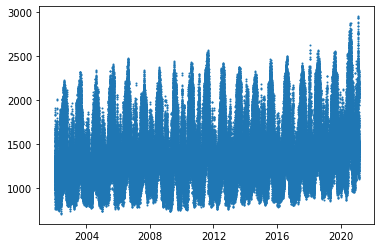

In [13]:
plt.plot_date(x=df['Hour_End'],y=df['EAST'],markersize=1);

To get a sense of the data contents, zoom in on the first few data points

The sampling is once per hour, so to get 5 days we an look at the first 24*5 data points

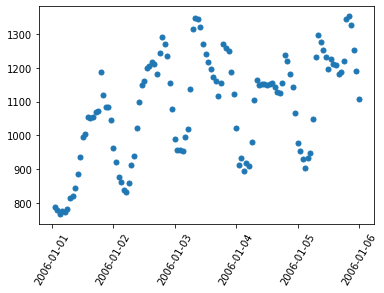

In [14]:
max_ct = 24*5
plt.plot_date(x=df['Hour_End'][0:max_ct],y=df['EAST'][0:max_ct],markersize=5);
plt.xticks(rotation=60);

Take a look at the first month. We can see there are weekly patterns

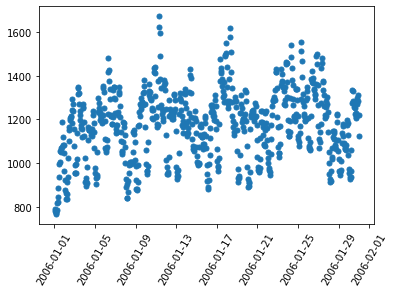

In [15]:
max_ct = 24*30
plt.plot_date(x=df['Hour_End'][0:max_ct],y=df['EAST'][0:max_ct],markersize=5);
plt.xticks(rotation=60);

As expected, there are daily, weekly, and annual patterns

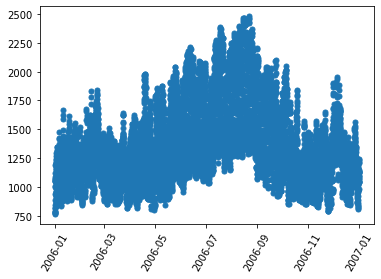

In [16]:
max_ct = 24*365
plt.plot_date(x=df['Hour_End'][0:max_ct],y=df['EAST'][0:max_ct],markersize=5);
plt.xticks(rotation=60);

There are 9 columns, one per region of monitoring

<img src="http://www.ercot.com/content/wcm/landing_pages/88828/Weather_Map.png" width="300" align='left'>

We can plot each of these columns to see the differences

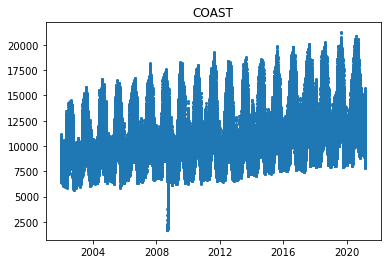

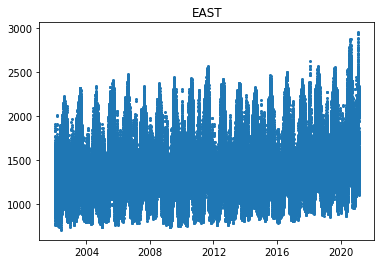

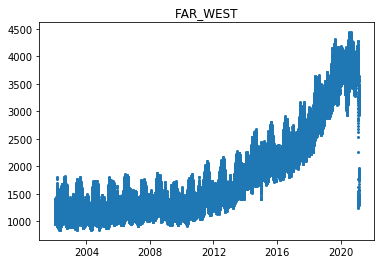

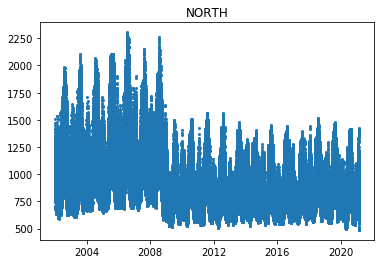

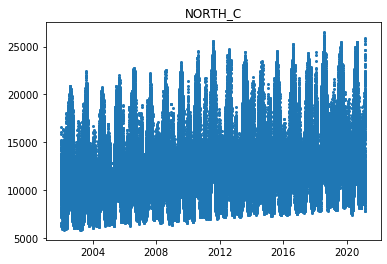

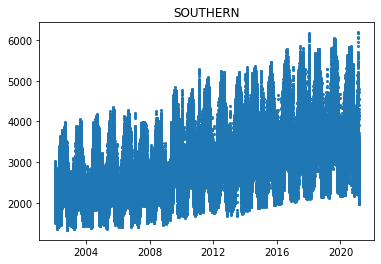

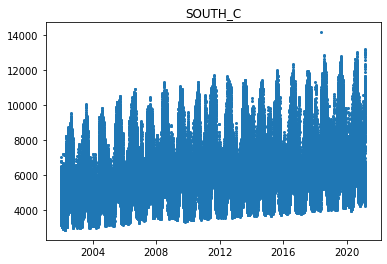

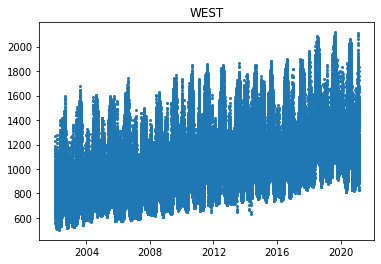

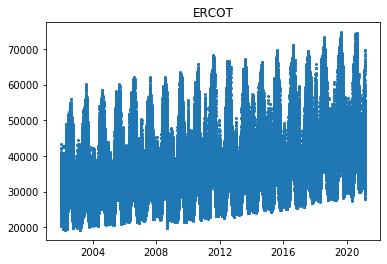

In [17]:
for column_name in df.columns:
    if column_name not in ['Hour_End', 'index']:
        plt.plot_date(x=df['Hour_End'],y=df[column_name],label=column_name,markersize=2)
        plt.title(column_name)
        plt.show()

# lag plot - compare each point to previous point

If data isn't a time series, we would see a circular blog of points, indicating order doesn't matter

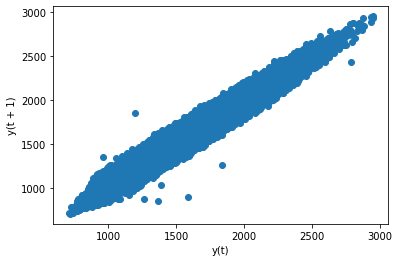

In [18]:
pd.plotting.lag_plot(df['EAST']);

# autocorrelation measures many lags

See the topic https://en.wikipedia.org/wiki/Autocorrelation, specifically here we are creating a https://en.wikipedia.org/wiki/Correlogram

"Calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation." (<a href="https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/">source</a>)

"If time series is random, such autocorrelations should be near zero for any and all time-lag separations." (<a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-autocorrelation">source</a>)

https://data.blog/2018/07/24/investigating-seasonality-in-a-time-series-a-mystery-in-three-parts/

elapsed: 19.830759048461914 seconds


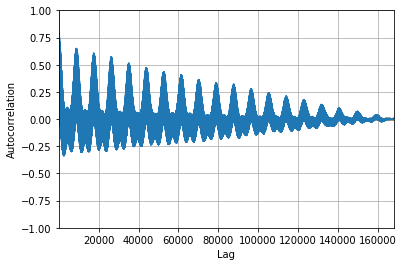

In [19]:
start_time=time.time()
pd.plotting.autocorrelation_plot(df['EAST']);
print('elapsed:',time.time()-start_time,'seconds')

A similar option is to use the statsmodels library

https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

"Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke."" (<a href="https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/">source</a>)

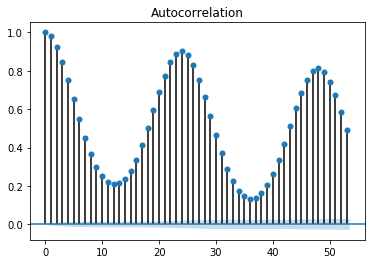

In [20]:
_=plot_acf(df['EAST'])

we can zoom in on the correlations that are outside the cone

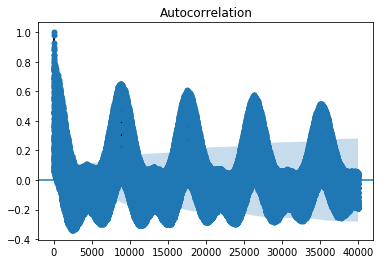

In [21]:
_=plot_acf(df['EAST'],lags=40000)

In [22]:
365*24

8760

# temporal decomposition

In [23]:
df_2020 = df[df['Hour_End'].apply(lambda x: x.year==2006)]

In [24]:
df_2020.head()

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2006-01-01 01:00:00.003,7623.394894,788.305875,1026.559049,777.157535,7549.809438,1852.416802,3797.223989,639.553370,24054.420954
1,2006-01-01 01:59:59.997,7437.102525,779.587442,1024.320168,752.171350,7291.494704,1770.283786,3637.505535,628.083900,23320.549410
2,2006-01-01 03:00:00.000,7151.481479,767.310985,1011.297406,725.028737,7012.269706,1676.891230,3482.207530,614.014931,22440.502004
3,2006-01-01 04:00:00.003,6957.302786,774.671447,1004.026250,711.968331,6896.466664,1609.080496,3363.417807,611.227308,21928.161089
4,2006-01-01 04:59:59.997,6861.596790,772.916673,1005.141879,708.933070,6810.395549,1595.417621,3303.547499,613.746434,21671.695516


# smoothing out noise using rolling average

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [25]:
df['EAST'].rolling(window=5).mean().head(15)

0             NaN
1             NaN
2             NaN
3             NaN
4      776.558484
5      775.426883
6      782.572365
7      793.149122
8      806.756460
9      829.287177
10     860.090533
11     896.347190
12     933.249232
13     975.813876
14    1008.704671
Name: EAST, dtype: float64

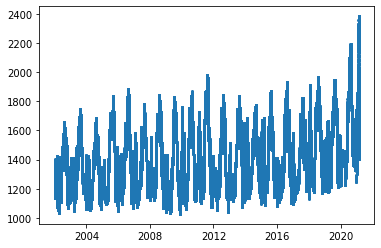

In [26]:
# window size of one week (7 days and 24 hours)
plt.plot_date(x=df['Hour_End'],y=df['EAST'].rolling(window=7*24).mean(),markersize=2);

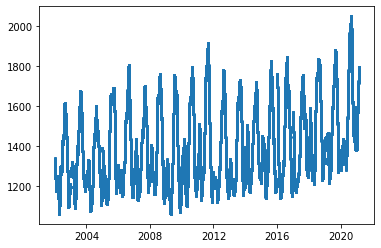

In [27]:
# window size of one month (30 days and 24 hours)
plt.plot_date(x=df['Hour_End'],y=df['EAST'].rolling(window=30*24).mean(),markersize=2);

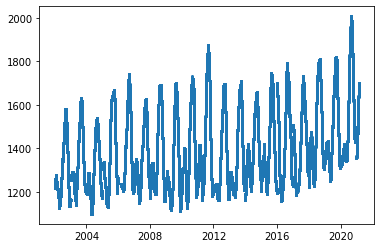

In [28]:
# window size of two months (60 days and 24 hours)
plt.plot_date(x=df['Hour_End'],y=df['EAST'].rolling(window=60*24).mean(),markersize=2);

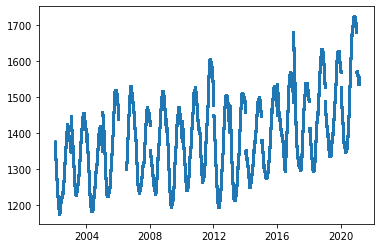

In [29]:
plt.plot_date(x=df['Hour_End'],y=df['EAST'].rolling(window=365*12).mean(),markersize=2);

### A window that is too large loses the signal and the noise

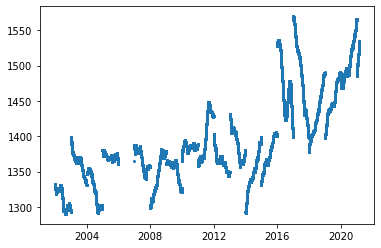

In [30]:
# window size of one year (365 days and 24 hours)
plt.plot_date(x=df['Hour_End'],y=df['EAST'].rolling(window=365*24).mean(),markersize=2);

# Seasonal decomposition

https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

https://github.com/statsmodels/statsmodels/blob/master/statsmodels/tsa/seasonal.py

First, a reminder of the contents of Hour_End column

In [31]:
df['Hour_End'][0]

0   2006-01-01 01:00:00.003
0   2010-01-01 01:00:00.003
0   2007-01-01 01:00:00.003
0   2011-01-01 01:00:00.003
0   2013-01-01 01:00:00.003
0   2005-01-01 01:00:00.003
0   2009-01-01 01:00:00.003
0   2002-01-01 01:00:00.003
0   2014-01-01 01:00:00.003
0   2003-01-01 01:00:00.003
0   2015-01-01 01:00:00.003
0   2012-01-01 01:00:00.003
0   2004-01-01 01:00:00.003
0   2008-01-01 01:00:00.003
0   2018-01-01 01:00:00.000
0   2020-01-01 01:00:00.000
0   2017-01-01 01:00:00.000
0   2019-01-01 01:00:00.000
0   2021-01-01 01:00:00.000
0   2016-01-01 01:00:00.003
Name: Hour_End, dtype: datetime64[ns]

the sampling is once per hour

In [32]:
df['Hour_End'][0:5]

0   2006-01-01 01:00:00.003
1   2006-01-01 01:59:59.997
2   2006-01-01 03:00:00.000
3   2006-01-01 04:00:00.003
4   2006-01-01 04:59:59.997
Name: Hour_End, dtype: datetime64[ns]

Let's inspect the "EAST" columns versus Hour_End.

To get a picture with timestamps on the x-axis, we need to convert the twol columns to a series with a timestamp as the index

In [33]:
data_series = pd.Series(df['EAST'].values, index=df['Hour_End'])
data_series.head()

Hour_End
2006-01-01 01:00:00.003    788.305875
2006-01-01 01:59:59.997    779.587442
2006-01-01 03:00:00.000    767.310985
2006-01-01 04:00:00.003    774.671447
2006-01-01 04:59:59.997    772.916673
dtype: float64

Now we can pass the series to seasonal_decompose and inspect the first 10 days

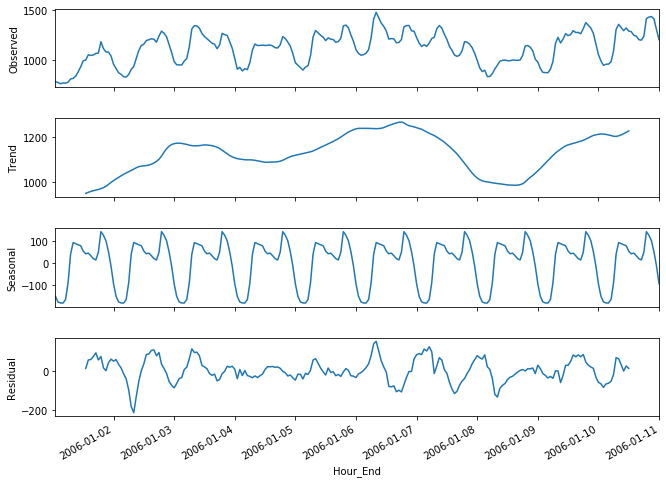

In [34]:
result  = seasonal_decompose(data_series[0:24*10], model='additive',freq=24) # freq is the cycle length in number of periods
result.plot()
plt.gcf().set_size_inches(10,8)
plt.show()

We can include more data points to see a weekly trend

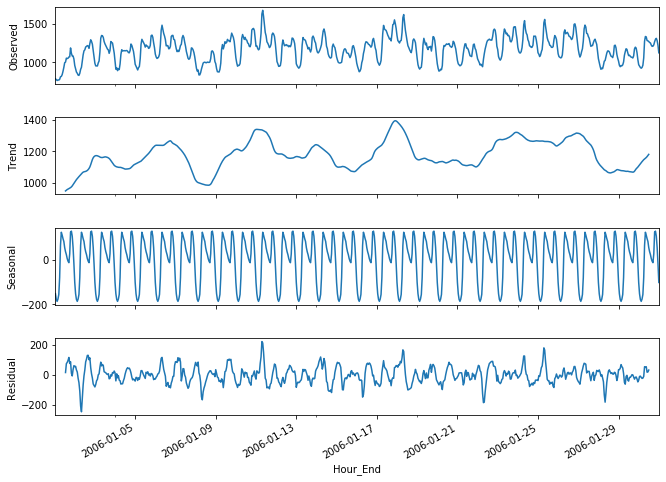

In [35]:
result  = seasonal_decompose(data_series[0:24*30], model='additive',freq=24) # freq is the cycle length in number of periods
result.plot()
plt.gcf().set_size_inches(10,8)
plt.show()

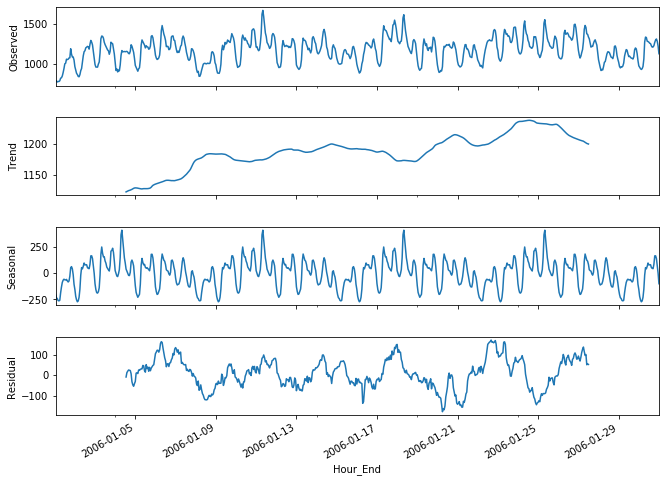

In [36]:
result  = seasonal_decompose(data_series[0:24*30], model='additive',freq=24*7) # freq is the cycle length in number of periods
result.plot()
plt.gcf().set_size_inches(10,8)
plt.show()

Next we can filter out only values where the year is 2020

In [38]:
data_series_2020 = pd.Series(df_2020['EAST'].values, index=df_2020['Hour_End'])
data_series_2020.head()

Hour_End
2006-01-01 01:00:00.003    788.305875
2006-01-01 01:59:59.997    779.587442
2006-01-01 03:00:00.000    767.310985
2006-01-01 04:00:00.003    774.671447
2006-01-01 04:59:59.997    772.916673
dtype: float64

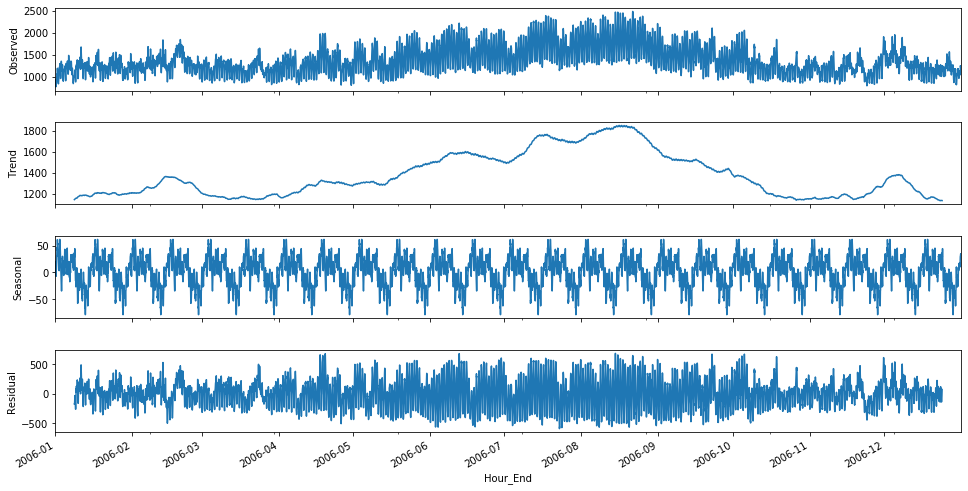

In [39]:
result  = seasonal_decompose(data_series_2020, model='additive',freq=365) # freq is the cycle length in number of periods
result.plot()
plt.gcf().set_size_inches(15,8)
plt.show()

In [40]:
data_series = pd.Series(df['EAST'].values, index=df['Hour_End'])
data_series.head()

Hour_End
2006-01-01 01:00:00.003    788.305875
2006-01-01 01:59:59.997    779.587442
2006-01-01 03:00:00.000    767.310985
2006-01-01 04:00:00.003    774.671447
2006-01-01 04:59:59.997    772.916673
dtype: float64

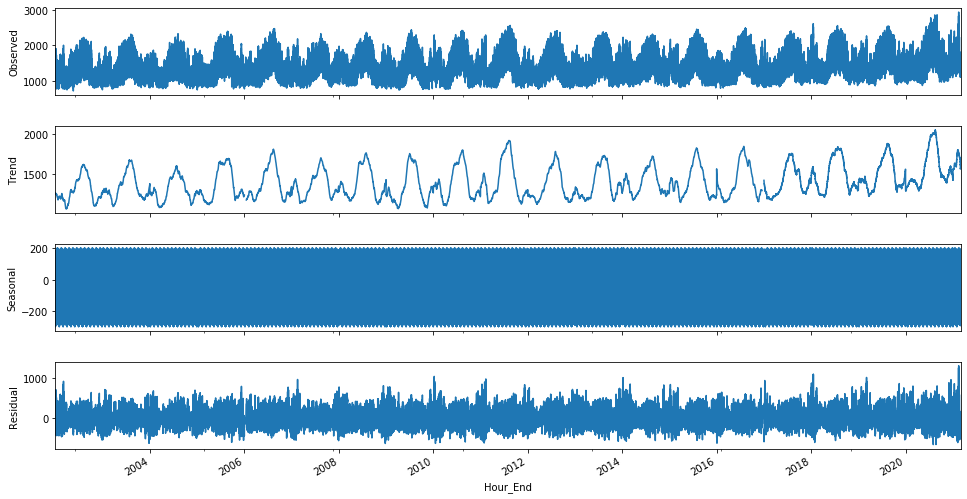

In [41]:
result  = seasonal_decompose(data_series, model='additive',freq=30*24) # freq is the cycle length in number of periods
#result = seasonal_decompose(df['EAST'].values, model='additive',freq=30*24) # freq is the cycle length in number of periods
result.plot()
plt.gcf().set_size_inches(15,8)
plt.show()